In [47]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets
import pandas as pd
import io

# generating training dataset


In [48]:
train_data = np.loadtxt("Train_Data.txt", delimiter=',', dtype=str)
test_data = np.loadtxt("Test_Data.txt", delimiter=',', dtype=str)

In [49]:
column_names = ['ID', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'class']


df_train = pd.DataFrame(train_data, columns=column_names)
df_test = pd.DataFrame(test_data, columns=column_names)


print(df_train)
print(df_test)

          ID x1 x2 x3 x4 x5  x6 x7 x8 x9 class
0    1000025  5  1  1  1  2   1  3  1  1     2
1    1002945  5  4  4  5  7  10  3  2  1     2
2    1015425  3  1  1  1  2   2  3  1  1     2
3    1016277  6  8  8  1  3   4  3  7  1     2
4    1017023  4  1  1  3  2   1  3  1  1     2
..       ... .. .. .. .. ..  .. .. .. ..   ...
594  1315506  4  8  6  3  4  10  7  1  1     4
595  1320141  5  1  1  1  2   1  2  1  1     2
596  1325309  4  1  2  1  2   1  2  1  1     2
597  1333063  5  1  3  1  2   1  3  1  1     2
598  1333495  3  1  1  1  2   1  2  1  1     2

[599 rows x 11 columns]
         ID x1  x2  x3 x4 x5 x6  x7  x8 x9 class
0   1334659  5   2   4  1  1  1   1   1  1     2
1   1336798  3   1   1  1  2  1   2   1  1     2
2   1344449  1   1   1  1  1  1   2   1  1     2
3   1350568  4   1   1  1  2  1   2   1  1     2
4   1352663  5   4   6  8  4  1   8  10  1     4
..      ... ..  ..  .. .. .. ..  ..  .. ..   ...
95   776715  3   1   1  1  3  2   1   1  1     2
96   841769  2   1 

## Feature Selection or Manipulation
#### + test set preparation

In [ ]:
df_train = df_train.replace('?', '0') 
df_test = df_test.replace('?', '0')

feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
features_to_use = [ 'x2/2', 'x3', 'x4/2', 'x6', 'x8/2','x9']

for col in feature_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce') 
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

df_train['class'] = pd.to_numeric(df_train['class'], errors='coerce')
df_test['class'] = pd.to_numeric(df_test['class'], errors='coerce')


# #Feature Modification
df_train['x2/2'] = df_train['x2'] /2
df_test['x2/2'] = df_test['x2']/  2
df_train['x4/2'] = df_train['x4'] / 2
df_test['x4/2'] = df_test['x4']/  2
df_train['x8/2'] = df_train['x8'] /2
df_test['x8/2'] = df_test['x8']/  2


X = df_train[features_to_use].values.astype(np.float32) 
Xt = df_test[features_to_use].values.astype(np.float32)

Y = df_train['class'].replace({4.0: 1.0, 2.0: 0.0}).values.astype(np.float32)
Yt = df_test['class'].replace({4.0: 1.0, 2.0: 0.0}).values.astype(np.float32)

#Standardize
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_train_scaled = (X - X_mean) / X_std

X_test_scaled = (Xt - X_mean) / X_std

x_train = torch.from_numpy(X_train_scaled).type(torch.float32)
y_train = torch.from_numpy(Y).type(torch.float32).unsqueeze(1)

x_test = torch.from_numpy(X_test_scaled).type(torch.float32)
y_test = torch.from_numpy(Yt).type(torch.float32).unsqueeze(1)


input_size = x_train.shape[1]
print(x_train.shape)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")


torch.Size([599, 6])
x_train shape: torch.Size([599, 6])
y_train shape: torch.Size([599, 1])


# Define model class

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, 1)

  def forward(self, x):
    pred = torch.sigmoid(self.linear(x))
    return pred

  def predict(self, x):
    pred = self.forward(x)
    return torch.round(pred)

print(x_train.shape)

torch.manual_seed(1)
model = LogisticRegression()



torch.Size([599, 6])
[Parameter containing:
tensor([[ 0.2104, -0.1802, -0.0791,  0.1916, -0.3843,  0.2448]],
       requires_grad=True), Parameter containing:
tensor([-0.0840], requires_grad=True)]


# function to get model parameters (w1, w2, b)

In [ ]:
[w, b] = model.parameters()
print(w)

w_all = w.view(-1)
if len(features_to_use) == 1:
  w1 = w_all[0]
  w2 = 0
else:
  w1 = w_all[0]
  w2 = w_all[1]

def get_params():
  return (w1.item(), w2.item(), b[0].item())

Parameter containing:
tensor([[ 0.2104, -0.1802, -0.0791,  0.1916, -0.3843,  0.2448]],
       requires_grad=True)


# training the model 

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# training the model 
epochs = 400
losses = []

for i in range(epochs):
  y_pred = model.forward(x_train)


  loss = criterion(y_pred, y_train)

  # regularizer
  # l1_lambda = 0.035
  # l2_lambda = 0.051

  #test value - without regularization
  # l1_lambda = 0
  # l2_lambda = 0

  first_param = next(model.parameters())
  l1_reg = first_param.new_tensor(0.)
  l2_reg = first_param.new_tensor(0.)
  for param in model.parameters():
      l1_reg.add_(torch.norm(param, 1))
      l2_reg.add_(torch.norm(param, 2))
      loss += l1_lambda * l1_reg + l2_lambda * l2_reg

  print("epoch: ", i, "loss: ", loss.item())
  losses.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

epoch:  0 loss:  0.7163392901420593
epoch:  1 loss:  0.7008334994316101
epoch:  2 loss:  0.6724668741226196
epoch:  3 loss:  0.6344401240348816
epoch:  4 loss:  0.5901374816894531
epoch:  5 loss:  0.5427791476249695
epoch:  6 loss:  0.4951324760913849
epoch:  7 loss:  0.4493288993835449
epoch:  8 loss:  0.40680763125419617
epoch:  9 loss:  0.3683737516403198
epoch:  10 loss:  0.33432748913764954
epoch:  11 loss:  0.3046133518218994
epoch:  12 loss:  0.2789560854434967
epoch:  13 loss:  0.2569653391838074
epoch:  14 loss:  0.23820826411247253
epoch:  15 loss:  0.2222549319267273
epoch:  16 loss:  0.20870423316955566
epoch:  17 loss:  0.19719578325748444
epoch:  18 loss:  0.18741419911384583
epoch:  19 loss:  0.17908816039562225
epoch:  20 loss:  0.17198677361011505
epoch:  21 loss:  0.16591542959213257
epoch:  22 loss:  0.16071060299873352
epoch:  23 loss:  0.15623556077480316
epoch:  24 loss:  0.15237608551979065
epoch:  25 loss:  0.14903683960437775
epoch:  26 loss:  0.146138176321983

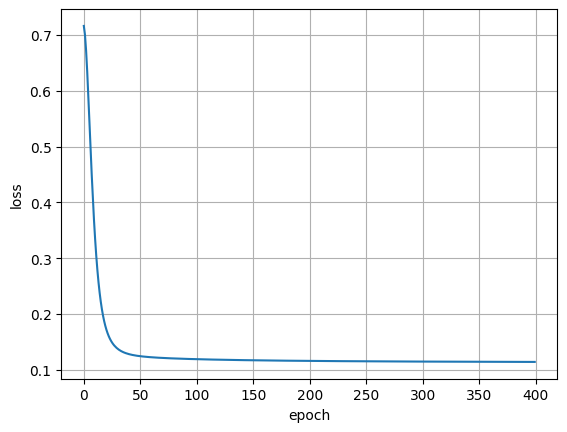

In [ ]:
# log loss
plt.plot(range(epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

# model evalation with new datasets the model has never seen before

In [ ]:
# 평가 코드
model.eval()
with torch.no_grad():
    y_pred_train = model.predict(x_train)

no_correct_train = y_pred_train.eq(y_train).sum().item()

accuracy_train = no_correct_train / len(x_train) * 100
print(f"accuracy_train= {accuracy_train:.10f}%")


with torch.no_grad():
    y_pred_test = model.predict(x_test)

no_correct_test = y_pred_test.eq(y_test).sum().item()

accuracy_test = no_correct_test / len(x_test) * 100
print(f"accuracy_test= {accuracy_test:.10f}%")


accuracy_train= 95.4924874791%
accuracy_test= 100.0000000000%
